In [1]:
import os
import time

from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook, tnrange
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
sns.set(style="ticks", color_codes=True)

%matplotlib inline

In [2]:
start = time.time()
parquet_file = pq.ParquetFile('/scratch/t.cri.awoodard/indel-filtering/cgp_pindel_filtered_shuffled.parquet')
table = parquet_file.read()
df = table.to_pandas()
# df = df[:5000000]  # uncomment to test on data subset
print('read df in {:.1f} seconds'.format(time.time() - start))

read df in 88.9 seconds


In [3]:
df['filter'] = 'pass'
df.loc[df.FILTER == 'pseudo PON', 'filter'] = 'fails pseudo PON'
df.loc[(df.FILTER != 'pseudo PON') & (df.FILTER != 'PASS'), 'filter'] = 'fail'

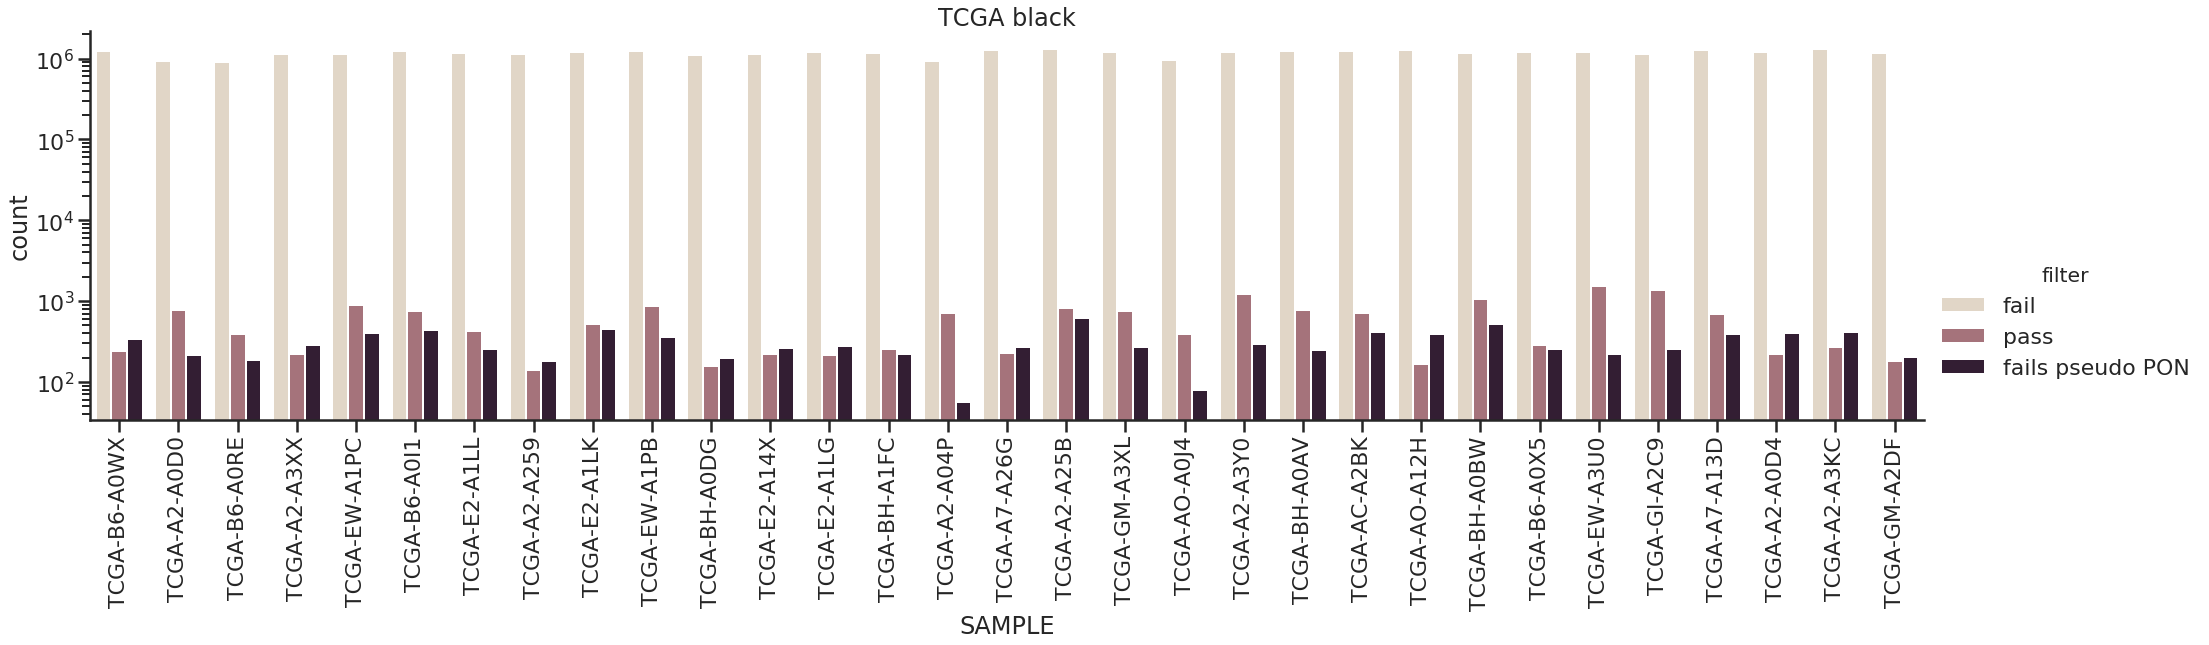

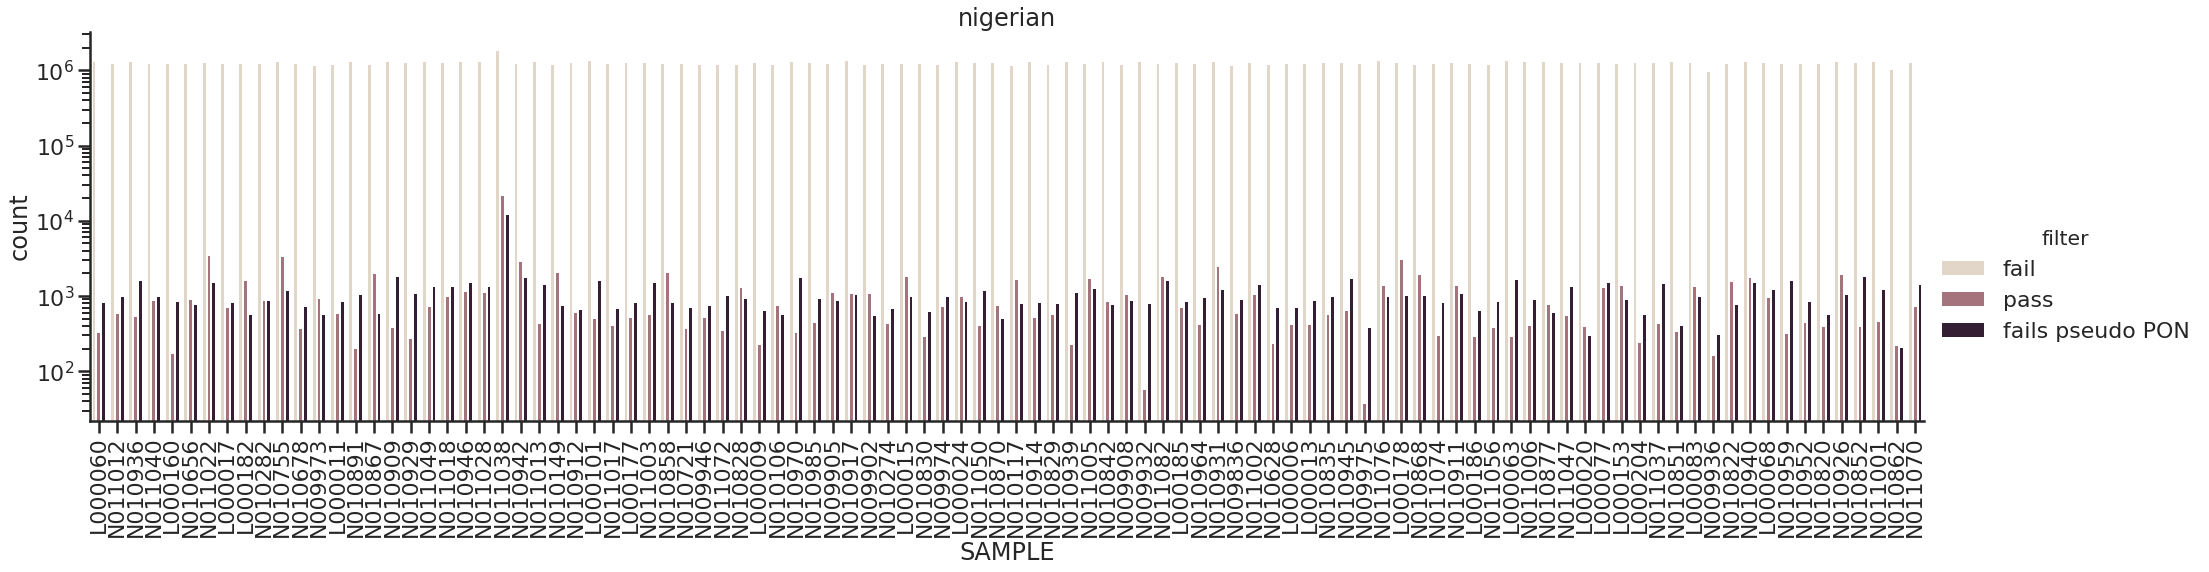

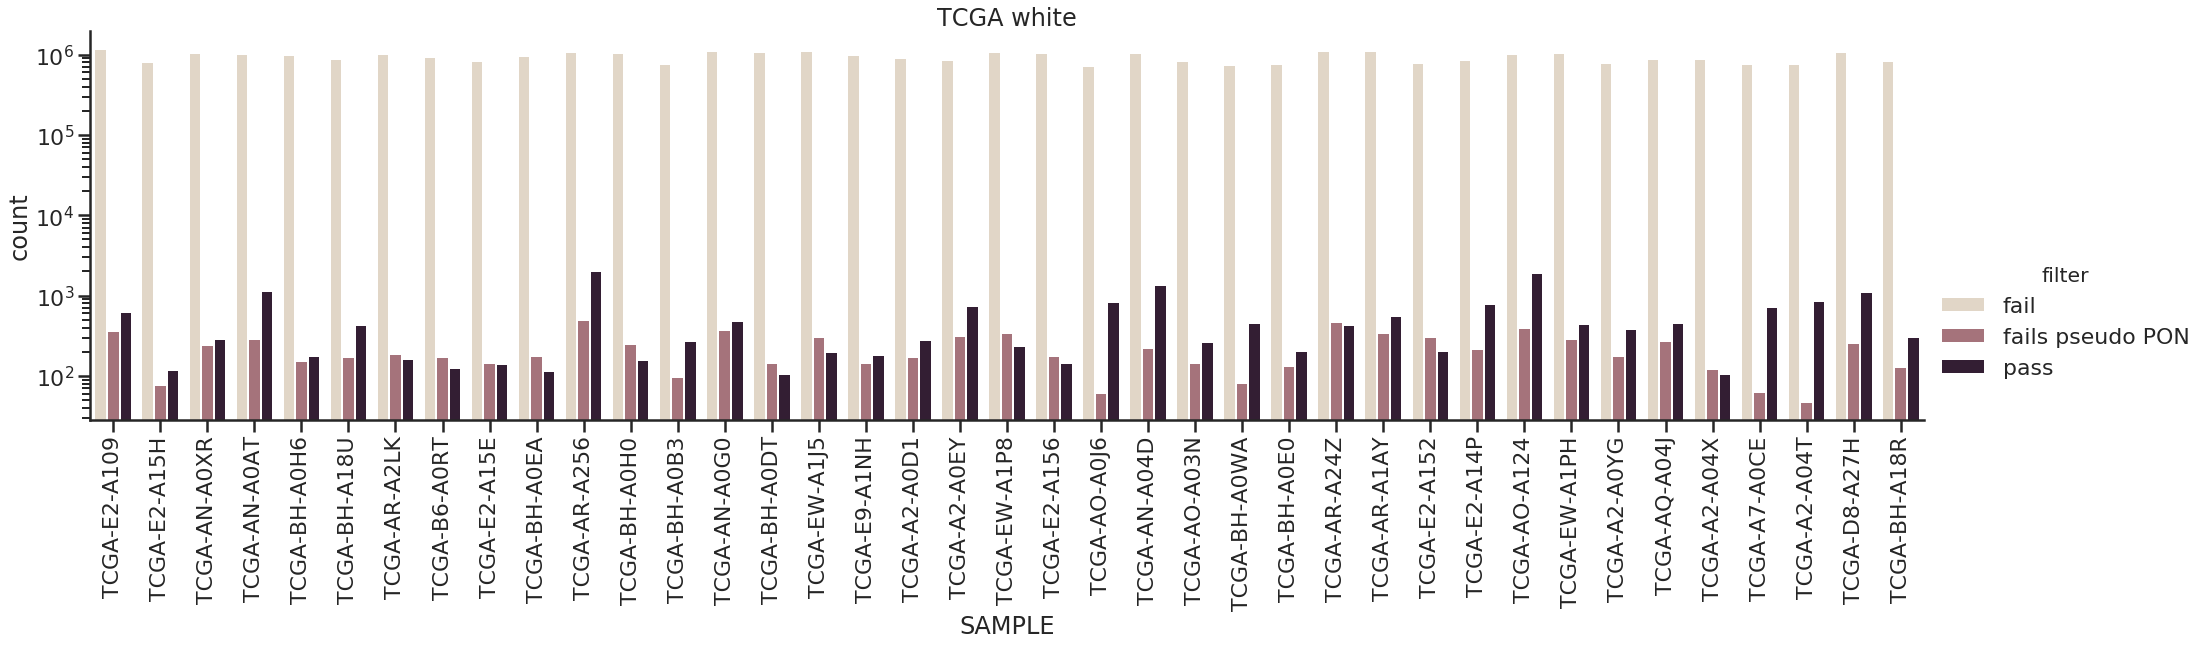

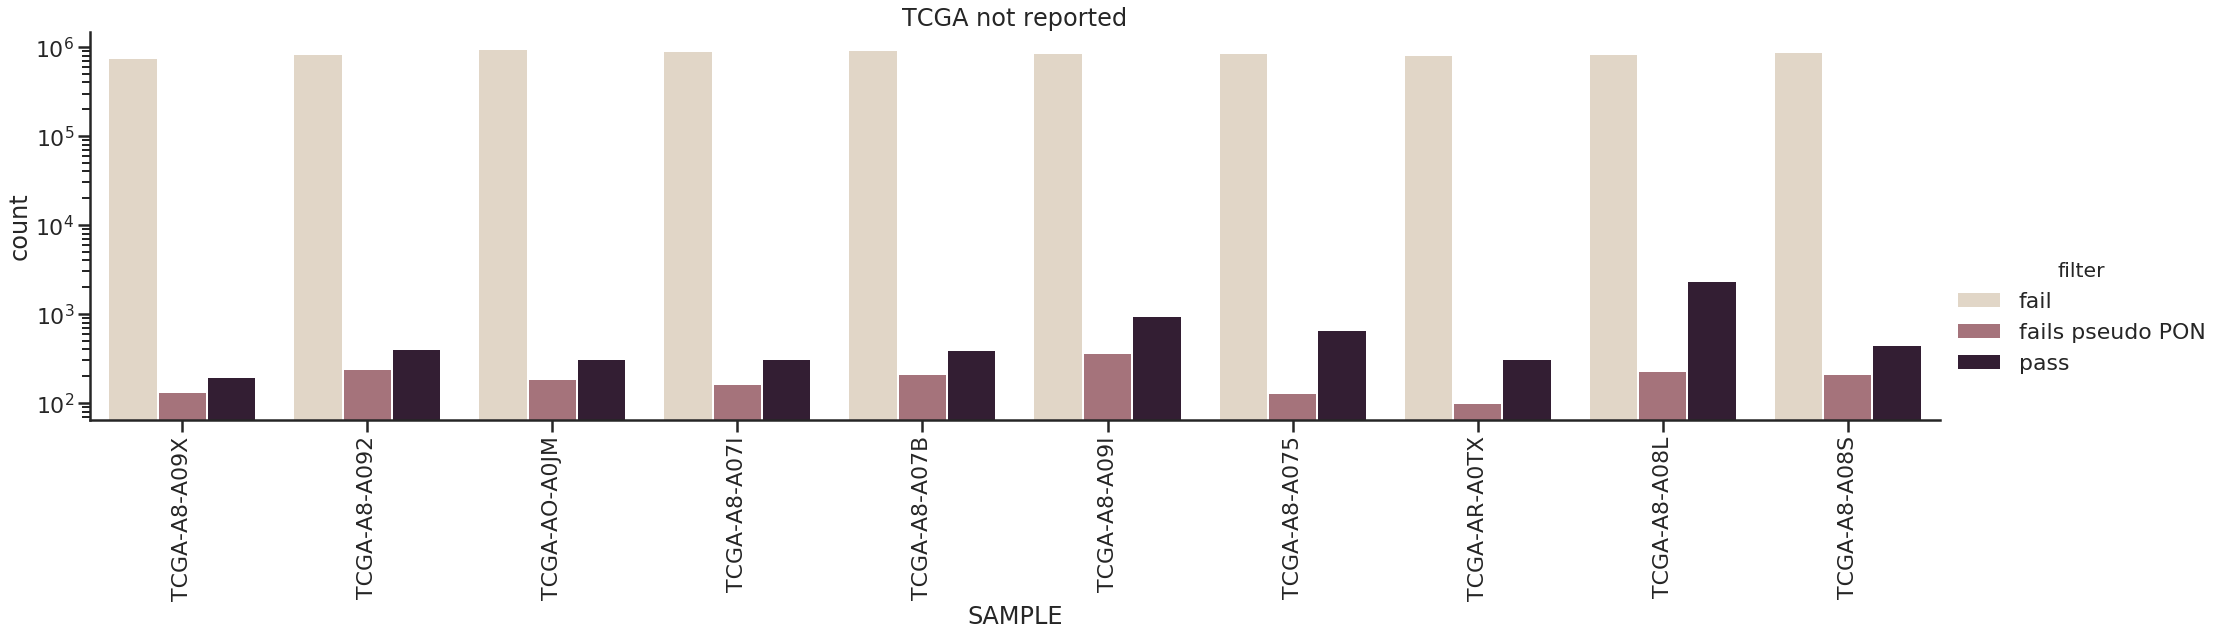

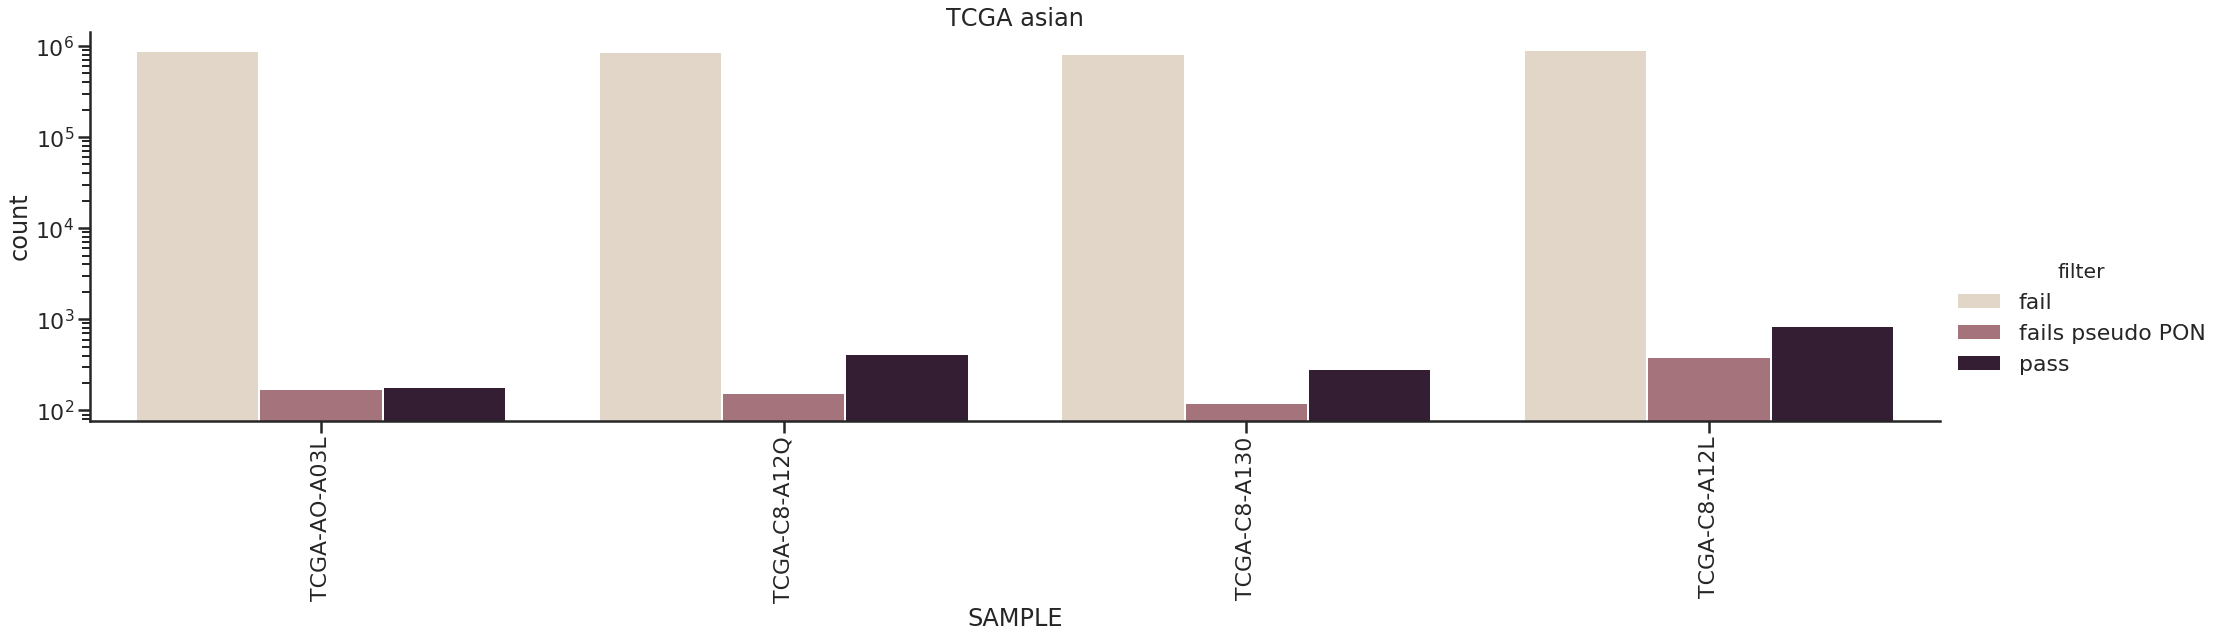

In [4]:
sns.set_context("poster", font_scale=1)
for race in df.RACE.unique():
    ax = sns.catplot(x="SAMPLE", hue="filter", kind="count", palette="ch:.25", data=df[df.RACE == race], height=7, aspect=4)
    ax.set_xticklabels(rotation=90)
    plt.yscale('log')
    plt.title(race)
    plt.savefig('plots/filter_counts_{}.pdf'.format(race.replace(' ', '_')))
    

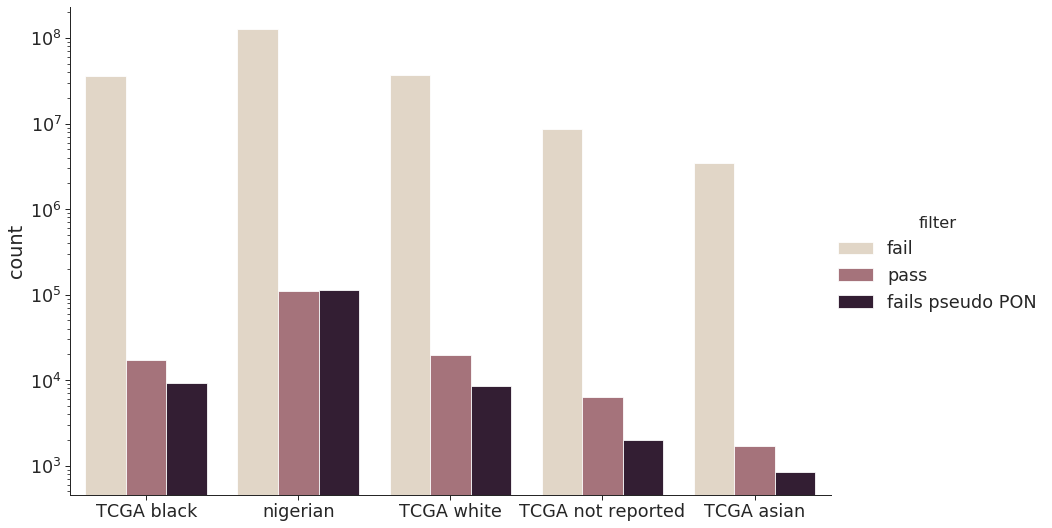

In [5]:
sns.set_context('paper', font_scale=2)
ax = sns.catplot(x="RACE", hue="filter", kind="count", palette="ch:.25", data=df, height=8.27, aspect=11.7/8.27)
plt.yscale('log')
plt.xlabel('')
plt.savefig('plots/pass_by_race.pdf')

In [72]:
summary = pd.DataFrame(data=
    {
        'race': sorted(df.RACE.unique()),
        'pass / fails pseudo PON' : ['{:.2f}%'.format(len(df.loc[(df['RACE'] == race) & (df['filter'] == 'pass')]) / len(df.loc[(df['RACE'] == race) & (df['filter'] == 'fails pseudo PON')])) for race in sorted(df.RACE.unique())],
      #  'pass / fail': ['{:.2f}%'.format(len(df.loc[(df['RACE'] == race) & (df['filter'] == 'pass')]) / len(df.loc[(df['RACE'] == race) & (df['filter'] == 'fail')]) * 100) for race in sorted(df.RACE.unique())],
      #  '(pass + fails pseudo PON) / fail': ['{:.2f}%'.format(len(df.loc[(df['RACE'] == race) & (df['filter'].isin(['pass', 'fails pseudo PON']))]) / len(df.loc[(df['RACE'] == race) & (df['filter'] == 'fail')]) * 100) for race in sorted(df.RACE.unique())]
    }
)
summary

,race,pass / fails pseudo PON
0,TCGA asian,2.05%
1,TCGA black,1.86%
2,TCGA not reported,3.19%
3,TCGA white,2.30%
4,nigerian,0.98%


In [11]:
columns = ['CHROM', 'POS', 'REF', 'ALT']

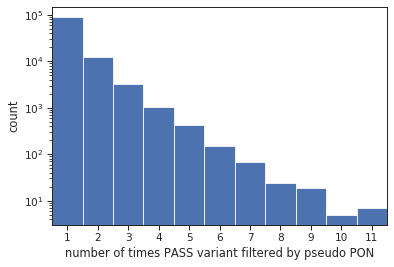

In [17]:
filtered_counts = df.loc[df['filter'] == 'fails pseudo PON'].groupby(columns).size().reset_index(name='counts')['counts']

sns.set_context('paper', font_scale=1.2)
ax = filtered_counts.hist(bins=range(filtered_counts.max()))
ax.set_xticks(np.arange(filtered_counts.max()) + .5)
ax.set_xticklabels(range(filtered_counts.max()))
ax.grid(False)
plt.yscale('log')
plt.xlim(1, filtered_counts.max() - 1)
plt.xlabel('number of times PASS variant filtered by pseudo PON')
plt.ylabel('count')
plt.savefig('plots/pseudo_pon_filtering_frequency.pdf', bbox_inches='tight')

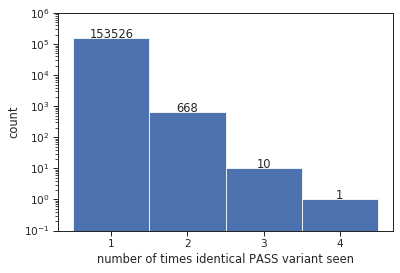

In [71]:
pass_counts = df.loc[df['FILTER'] == 'PASS'].groupby(columns).size().reset_index(name='counts')['counts']

bin_values, bin_edges = np.histogram(pass_counts, bins=np.arange(pass_counts.max() + 0.5) + 0.5)

ax = pass_counts.hist(bins=bin_edges)
ax.set_xticks(np.arange(filtered_counts.max()) + 1)
ax.set_xticklabels([i + 1 for i in range(filtered_counts.max())])
plt.grid(False)
plt.yscale('log')
plt.ylim(ymin=0.1, ymax=1e6)
plt.xlabel('number of times identical PASS variant seen')
plt.ylabel('count')

for i in range(len(bin_values)):
    plt.text(bin_edges[i] + 0.5, bin_values[i], str(bin_values[i]), ha='center')
    
plt.savefig('plots/pass_frequency.pdf', bbox_inches='tight')